# meshA_to_meshB vs Scipy griddata

In [1]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial     import ConvexHull, distance, Delaunay, KDTree, cKDTree
from scipy.optimize    import linprog
import time as TIME
import os
from scipy.stats import truncnorm

In [2]:
image_dir  = '//Images//'
parent_dir = os.getcwd()
parent_dir

'c:\\Users\\ketil\\Desktop\\UiB\\Fun projects\\meshA_to_meshB'

In [3]:
#os.chdir('your_dir_here') In case the cwd is not in the correct place...

In [4]:
from meshA_to_meshB_module import meshA_to_meshB

In [5]:
def plot_convex_hull(points, linestyle='-', linewidth=2, color='r', ax=None):
    hull = ConvexHull(points)
    if ax is None:
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], linestyle=linestyle, linewidth=linewidth, color=color)
    else:
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], linestyle=linestyle, linewidth=linewidth, color=color)

In [6]:
def plot_isclose(points_dense, points_sparse, f_dense, f_dense_scipy, rtol=1e-5, atol=1e-8, equal_nan=False, ax=None,
                 store=False, filenm='image.png'):
    x_dense = points_dense[:,0]
    y_dense = points_dense[:,1]
    if ax is None:
        plt.scatter(x_dense, y_dense, vmin=0.0, vmax=1.0, c=np.isclose(f_dense, f_dense_scipy, rtol=1e-5, atol=1e-8, 
                                                                       equal_nan=equal_nan).astype(int))
        plot_convex_hull(points_sparse, linestyle=':')
        plt.colorbar()
        plt.savefig(parent_dir+image_dir+filenm) if store else None
    else:
        ax.scatter(x_dense, y_dense, vmin=0.0, vmax=1.0, c=np.isclose(f_dense, f_dense_scipy, rtol=1e-5, atol=1e-8, 
                                                                       equal_nan=equal_nan).astype(int))
        plot_convex_hull(points_sparse, linestyle=':', ax=ax)
        

In [15]:
def plot_comparisons(points_sparse, points_dense, f_sparse, f_dense, f_dense_scipy, 
                     plot_markers=True, store=False, filenm='image.png'):
    
    x_sparse = points_sparse[:,0]
    y_sparse = points_sparse[:,1]
    x_dense  = points_dense[:,0]
    y_dense  = points_dense[:,1]
    
    fig, axs = plt.subplots(1,4,figsize=(16,6))

    axs[0].scatter(x_sparse,y_sparse,c=f_sparse, s=3)
    axs[0].set_title('Test data')

    axs[1].scatter(x_dense,y_dense,c=f_dense_scipy)
    axs[1].scatter(x_sparse,y_sparse,c='red', s=1) if plot_markers else None
    plot_convex_hull(points_sparse, linestyle=':', ax=axs[1])
    axs[1].set_title('Interpolated data scipy')

    axs[2].scatter(x_dense,y_dense,c=f_dense)
    axs[2].scatter(x_sparse,y_sparse,c='red', s=1) if plot_markers else None
    plot_convex_hull(points_sparse, linestyle=':', ax=axs[2])
    axs[2].set_title('Interpolated data meshA_to_meshB')

    plot_isclose(points_dense, points_sparse, f_dense, f_dense_scipy, equal_nan=True, ax=axs[3])
    axs[3].set_title('np.isclose()')
    
    fig.savefig(parent_dir+image_dir+filenm) if store else None
    

In [17]:
def plot_times(deltas):
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    ax.loglog(deltas[:,0], deltas[:,1])
    ax.loglog(deltas[:,0], deltas[:,2])
    ax.loglog(deltas[:,0], deltas[:,3])
    ax.legend(['scipy griddata', 'meshA_to_meshB no extrap', 'meshA_to_meshB with extrap'])
    ax.set_xlabel('N interpolation points')
    ax.set_ylabel('Average interpolation time (s)')

In [18]:
def compare_times(N_list, extrap_nans, extrap_from_A, fill_value, extrap_qhull, iterations=3):
    
    x_mid = 0.75
    y_mid = 1/2
    
    dx = 0.3
    dy = 0.3
    
    x = np.linspace(x_mid-dx,x_mid+dx,100)
    y = np.linspace(y_mid-dy,y_mid+dy,100)
    X,Y = np.meshgrid(x,y)
    points_dense = np.stack([X.flatten(),Y.flatten()], axis=-1)
    
    np.random.seed(1234)
    lower = 0
    upper = 1
    mu    = 1/2
    sigma = 0.12

    delta_sci_list    = []
    delta_mAmB_F_list = []
    delta_mAmB_T_list = []
    
    x_sparsest = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N_list[-1])
    y_sparsest = truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N_list[-1]) 
    points_sparsest = np.stack([x_sparsest, y_sparsest], axis=-1)
    
    hull = ConvexHull(points_sparsest)
    points_hull = points_sparsest[np.unique(hull.simplices)]
    hull_N = points_hull.shape[0]

    for N in N_list:

        x_sparse = np.concatenate([truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N), points_hull[:,0]])
        y_sparse = np.concatenate([truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N), points_hull[:,1]])
        f_sparse = np.random.rand(N+hull_N)

        points_sparse   = np.stack([x_sparse, y_sparse], axis=-1)
        sparse_to_dense = meshA_to_meshB(meshA_points=points_sparse, meshB_points=points_dense, extrap_qhull=extrap_qhull)


        start_sci = TIME.time()
        for i in range(iterations):
            f_dense_scipy = griddata(points_sparse, f_sparse, points_dense)
        end_sci = TIME.time()

        start_mAmB_F = TIME.time()
        for i in range(iterations):
            f_dense_F = sparse_to_dense.interpolate(f_sparse, extrap_nans=False,
                                                  extrap_from_A=extrap_from_A, fill_value=fill_value)
        end_mAmB_F = TIME.time()

        start_mAmB_T = TIME.time()
        for i in range(iterations):
            f_dense_T = sparse_to_dense.interpolate(f_sparse, extrap_nans=True, 
                                                  extrap_from_A=extrap_from_A, fill_value=fill_value)
        end_mAmB_T = TIME.time()

        delta_sci_list.append((end_sci-start_sci)/iterations)
        delta_mAmB_F_list.append((end_mAmB_F-start_mAmB_F)/iterations)
        delta_mAmB_T_list.append((end_mAmB_T-start_mAmB_T)/iterations)
    
    deltas = np.stack([N_list, delta_sci_list, delta_mAmB_F_list, delta_mAmB_T_list], axis=-1)
    
    plot_comparisons(points_sparse, points_dense, f_sparse, f_dense_F, f_dense_scipy, plot_markers=False)
    plot_comparisons(points_sparse, points_dense, f_sparse, f_dense_T, f_dense_scipy, plot_markers=False)
    plot_times(deltas)
    
    print(f'Time max scipy griddata:    {np.max(delta_sci_list):.2} s')
    print(f'Time max mAmB w/out extrap: {np.max(delta_mAmB_F_list):.2} s')
    print(f'Time max mAmB w/ extrap:    {np.max(delta_mAmB_T_list):.2} s\n')
    print(f'mAmB w/out extrap is maximum {(delta_sci_list[-1])/(delta_mAmB_F_list[-1]):.4} times faster') if delta_sci_list[-1] > delta_mAmB_F_list[-1] else print(f'mAmB w/ extrap is {(delta_mAmB_F_list[-1])/(delta_sci_list[-1]):.4} times slower')
    print(f'mAmB w/ extrap is maxiumum   {(delta_sci_list[-1])/(delta_mAmB_T_list[-1]):.4} times faster') if delta_sci_list[-1] > delta_mAmB_T_list[-1] else print(f'mAmB w/ extrap is {(delta_mAmB_T_list[-1])/(delta_sci_list[-1]):.4} times slower')
    

Time max scipy griddata:    3.2 s
Time max mAmB w/out extrap: 0.0008 s
Time max mAmB w/ extrap:    0.0037 s

mAmB w/out extrap is maximum 5.535e+03 times faster
mAmB w/ extrap is maxiumum   868.4 times faster


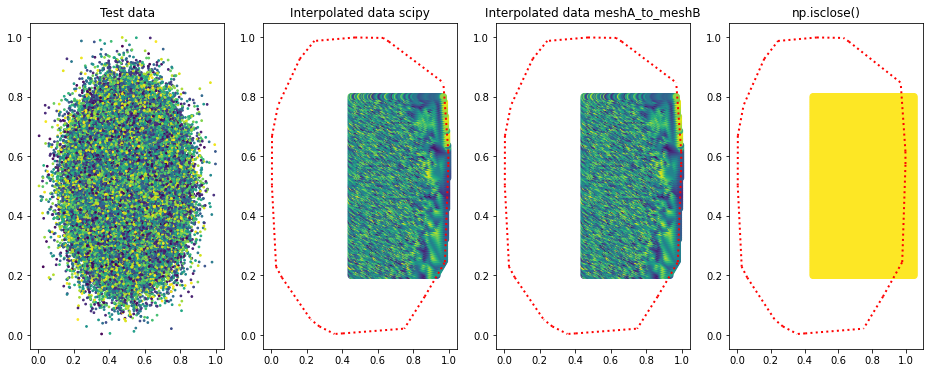

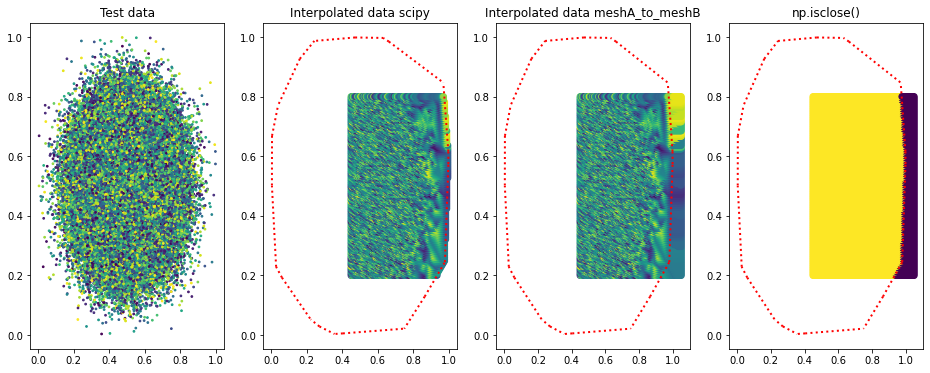

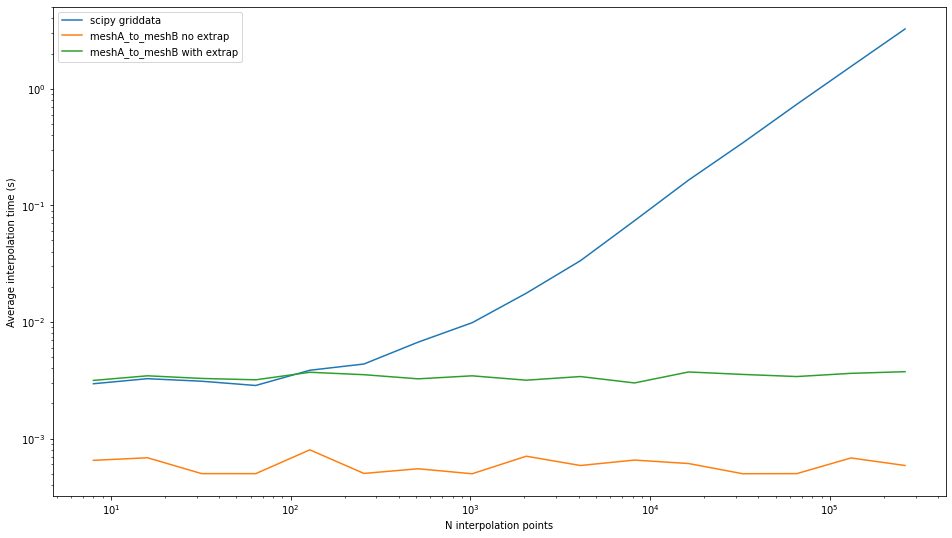

In [19]:
N_list = [8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768, 65536, 131072, 262144]
extrap_qhull  = False
extrap_nans   = False
extrap_from_A = False # False is slow for nearest if there are many points to extrapolate.
fill_value    = np.nan

compare_times(N_list, extrap_nans, extrap_from_A, fill_value, extrap_qhull, iterations=20)